In [1]:
import os, sys
sys.path.append('..') # Parent directory in path
from time import time, sleep
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import matplotlib.pylab as pl
import statsmodels.api as sm

pd.set_option("display.precision", 4)
#import pandas_market_calendars as mcal # NYSE Calendar

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16,10)

from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

[]

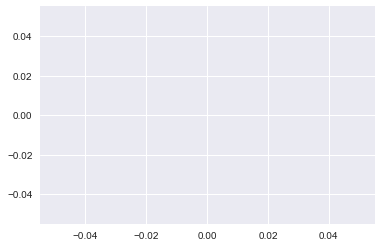

In [2]:
plt.plot() # bug with figure size

In [3]:
plt.rcParams["figure.figsize"] = (16,10)

In [4]:
# Import data from methodology_rates_iv
df = pd.read_pickle(os.path.join("..", "data", "IV_OLS.pkl"))
df.head()

,VOLUME,OPEN_INT,UNDERLYING_PRICE,BID_CLOSE,ASK_CLOSE,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA,...,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_ASK,DELTA_F_BID,DELTA_F_ASK
0,11,15111.0,2429.01,74.4,76.3,0.0878,0.5625,0.0028,-0.2181,6.4220,...,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7557,0.1167,0.1196,0.5090,0.5096
1,25,13822.0,2429.01,77.7,79.5,0.1350,-0.4489,0.0018,-0.2230,6.4486,...,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7557,0.1168,0.1196,-0.4909,-0.4904
2,0,5926.0,2429.01,87.8,89.7,0.1312,-0.4948,0.0019,-0.2133,6.5015,...,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7557,0.1114,0.1143,-0.5460,-0.5441
3,7,19022.0,2429.01,59.8,61.6,0.0878,0.4933,0.0028,-0.2146,6.5012,...,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7557,0.1115,0.1142,0.4540,0.4559
4,501,32564.0,2429.01,68.9,70.7,0.1393,-0.4058,0.0017,-0.2300,6.3201,...,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7557,0.1223,0.1251,-0.4403,-0.4409


In [5]:
# Add ATM_VOLS

ATM_vols = df[df["RANK"]==0]
df = pd.merge(df, ATM_vols[["TS", "IV_BID", "IV_ASK"]], left_on="TS", right_on="TS", 
              suffixes=(None, "_ATM"), how="left")

In [6]:
# Add useful columns
df["MONEYNESS"] = df["UNDERLYING_PRICE"] - df["STRIKE"]

df["MONEYNESS_F"] = df["STRIKE"]/df["F_T"]
df["LOG_MONEYNESS_F"] = np.log(df["MONEYNESS_F"])
# df["LOG_MONEYNESS_F_STANDARD_TIME"] = df["LOG_MONEYNESS_F"] / np.sqrt(df["CAL_DAYS"])

# df["LOG_MONEYNESS_F_STANDARD_STD"] = df["LOG_MONEYNESS_F"] / (np.sqrt(df["CAL_DAYS"])*(df["IV_BID_ATM"]+df["IV_ASK_ATM"])/2)

df["IV_BID_DIFF"] = df["IV_BID"] - df["IV_BID_ATM"]
df["IV_ASK_DIFF"] = df["IV_ASK"] - df["IV_ASK_ATM"]

df["IV_BID_RATIO"] = df["IV_BID"]/df["IV_BID_ATM"]
df["IV_ASK_RATIO"] = df["IV_ASK"]/df["IV_ASK_ATM"]

In [7]:
def plot_IV_2D(df, xlabel, ylabel, interval=5, otm=True, option_type="C"):
    fig, ax = plt.subplots()
    
    dates = df["TS"].unique()[::interval]
    
    # This sets the gradient of the colors
    colors = pl.cm.viridis(np.linspace(0,0.8,len(dates)))
    
    for i, date in enumerate(dates):
        to_plot = df[(df["TS"]==date)].sort_values(xlabel).copy()
        
        if otm:
            c_otm = (to_plot['TYPE']=='C') & (to_plot["STRIKE"] > to_plot["UNDERLYING_PRICE"])
            p_otm = (to_plot['TYPE']=='P') & (to_plot["STRIKE"] < to_plot["UNDERLYING_PRICE"])
            to_plot = to_plot[c_otm | p_otm]
        else:
            to_plot = to_plot[to_plot["TYPE"]==option_type]
            
        dte = to_plot["CAL_DAYS"].iloc[0]
        ax.plot(to_plot[xlabel], to_plot[ylabel], label="{} DTE".format(dte), color=colors[i])
        
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.set_title("{} vs {}".format(ylabel, xlabel), size=18)
    ax.legend()

# LOG-MONEYNESS

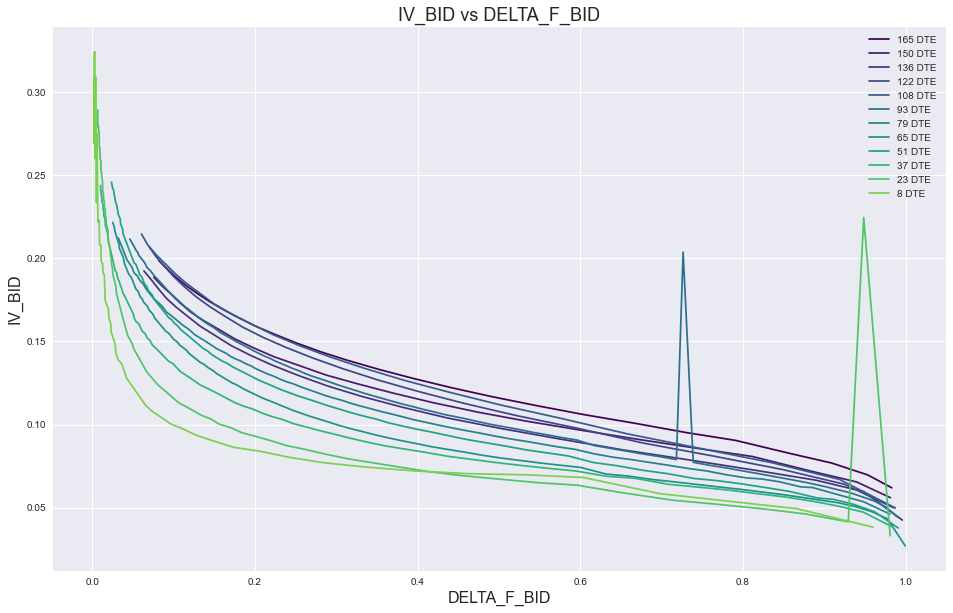

In [8]:
df["DELTA_F_BID"] = -df["DELTA_F_BID"] # flip sign for puts
df["DELTA_F_ASK"] = -df["DELTA_F_ASK"] # flip sign for puts

plot_IV_2D(df, "DELTA_F_BID", "IV_BID", interval=10, otm=False, option_type="P")

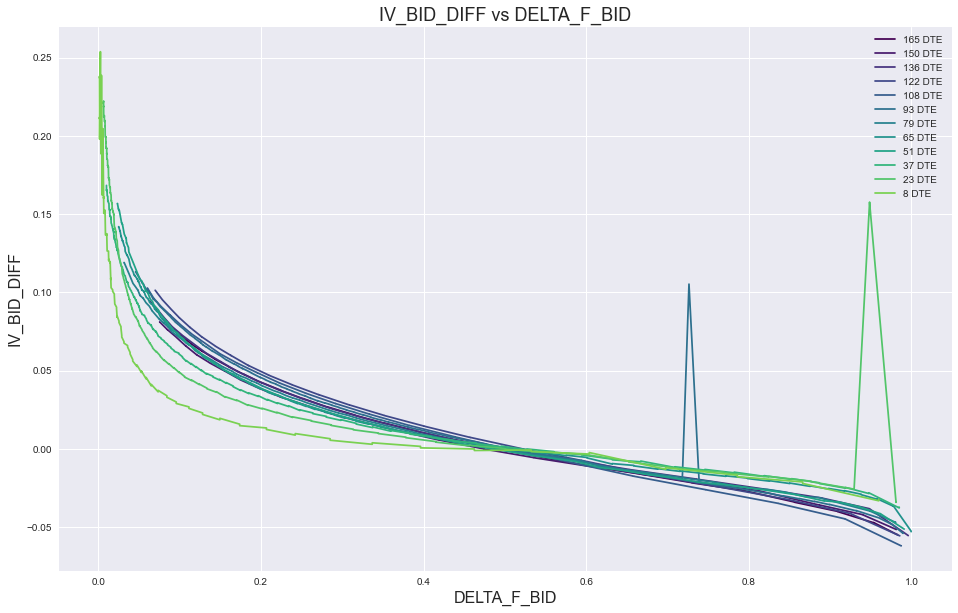

In [9]:
plot_IV_2D(df, "DELTA_F_BID", "IV_BID_DIFF", interval=10, otm=False, option_type="P")

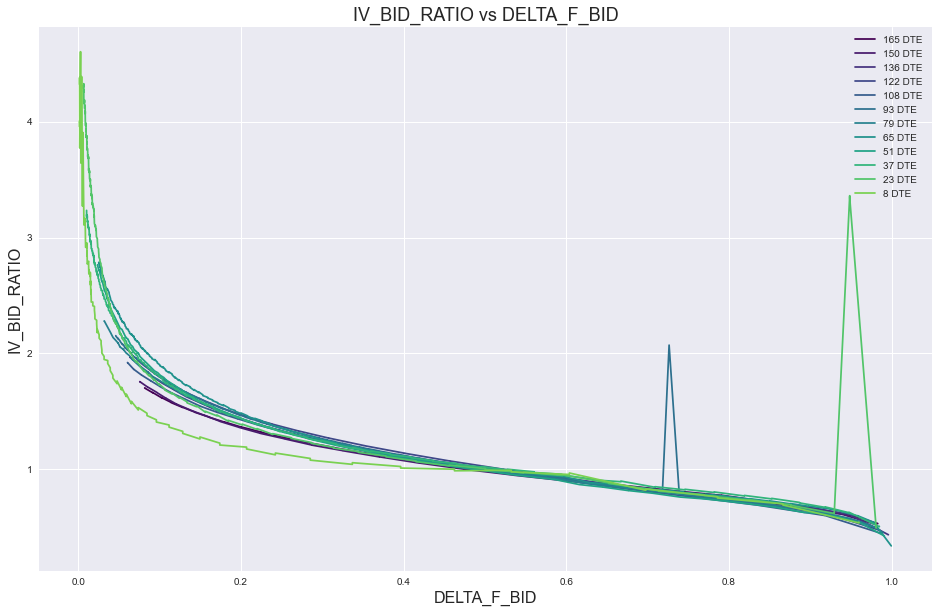

In [10]:
plot_IV_2D(df, "DELTA_F_BID", "IV_BID_RATIO", interval=10, otm=False, option_type="P")

# Example Fit

In [11]:
def sigmoid_inv(x, a, b, c, d):
    """Symmetric inverse sigmoid for scipy.optimize.curve_fit
    Asymptotes at 
    x=0, x=1"""
    return a * np.log(c/(x-d)-1) + b

def fit_sig(df):
    curve  = df.dropna()
    bounds = ((0, 0, -1.1, -0.1), (1, 1.1, 1.1, 0.1))
    guess  = (0.07, 1, 1.1, -0.05)
    popt, pcov = curve_fit(sigmoid_inv, curve["DELTA_F_BID"], curve["IV_BID_RATIO"], 
                           bounds=bounds, p0=guess)
    return popt

put_mask = (df["TYPE"]=='P')

to_fit = df[put_mask].copy().reset_index(drop=True)
# to_fit["DELTA_F_BID"] = -to_fit["DELTA_F_BID"] # flip sign for puts
# to_fit["DELTA_F_ASK"] = -to_fit["DELTA_F_ASK"] # flip sign for puts

THRESH = 0.0 # need to eliminate edge cases
bid_mask = (THRESH < df["DELTA_F_BID"]) & (df["DELTA_F_BID"] < (1-THRESH))
ask_mask = bid_mask # (THRESH < df["DELTA_F_ASK"]) & (df["DELTA_F_ASK"] < (1-THRESH))

to_fit = to_fit[bid_mask & ask_mask].reset_index(drop=True)

fits = to_fit.groupby("TS").apply(fit_sig)
temp = np.hstack(fits.values)
fits = temp.reshape((temp.shape[0]//4, 4))
X = np.linspace(THRESH,1-THRESH,100)
preds = [sigmoid_inv(X, *i) for i in fits]

# Example Fit

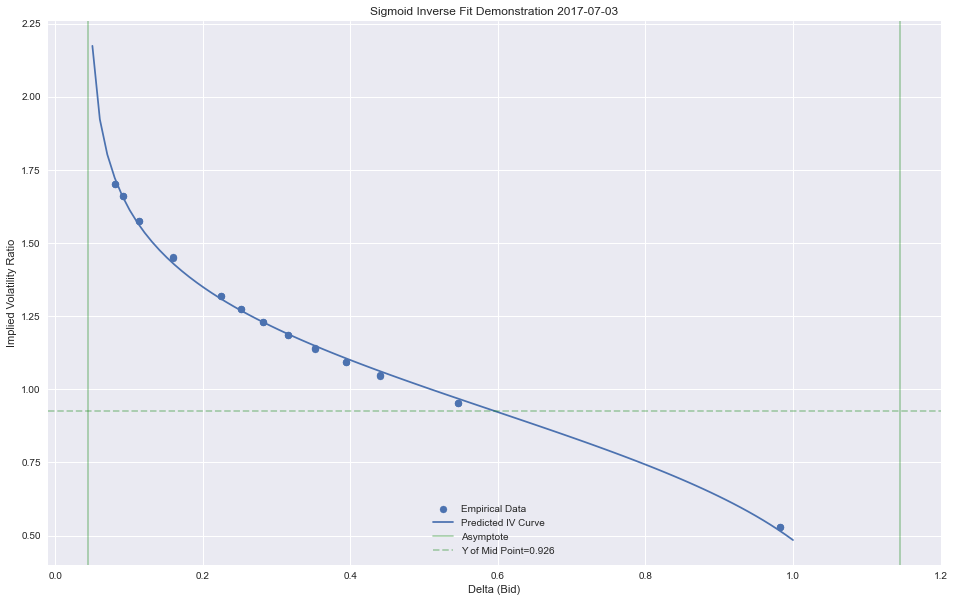

In [12]:
tss = to_fit["TS"].unique()

sel = 0
to_plot = to_fit[to_fit["TS"]==tss[sel]]
ft = fits[sel]
sll = ft[3]
slr = ft[2] + ft[3]
mid = ft[1]

plt.scatter(to_plot["DELTA_F_BID"], to_plot["IV_BID_RATIO"], label="Empirical Data")
plt.plot(X, preds[sel], label="Predicted IV Curve")

guessd = sigmoid_inv(X, *[0.07, 1, 1.5,-0.05])

plt.axvline(sll, color='g', alpha=0.3, label="Asymptote")
plt.axvline(slr, color='g', alpha=0.3)
plt.axhline(mid, color='g', alpha=0.3, linestyle="--", label=f"Y of Mid Point={mid:.3f}")

# plt.ylim([to_plot["IV_BID"].min()*0.9, to_plot["IV_BID"].max()*1.1])

plt.title(f"Sigmoid Inverse Fit Demonstration {str(tss[sel])[:10]}")
plt.xlabel("Delta (Bid)")
plt.ylabel("Implied Volatility Ratio")
plt.legend()
plt.show()

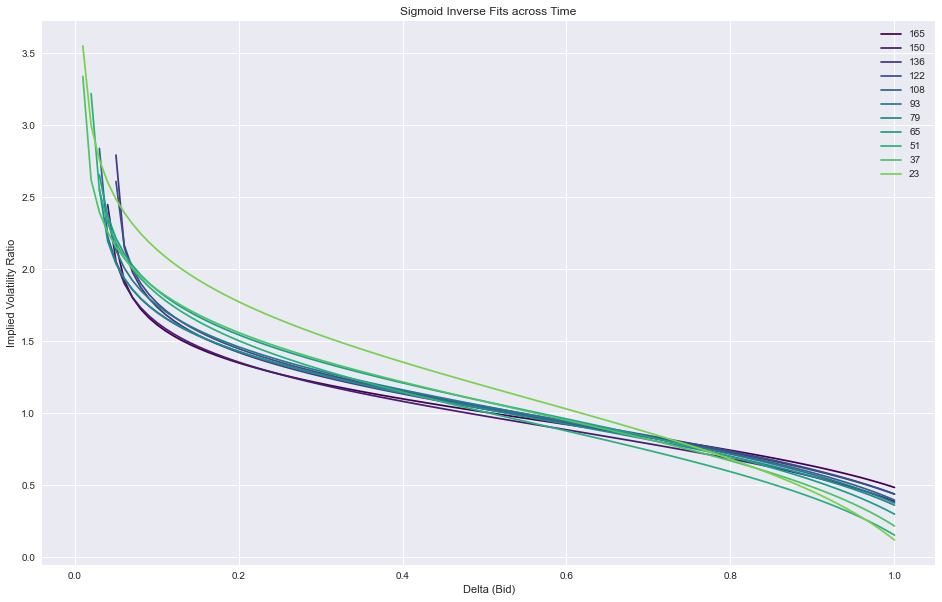

In [13]:
s = 10

dte = to_fit["CAL_DAYS"].unique()#[::s]
n = len(preds) // s
colors = pl.cm.viridis(np.linspace(0,0.8,n))

for i in range(n):
    plt.plot(X, preds[i*s], color=colors[i], label=dte[i*s])

plt.title("Sigmoid Inverse Fits across Time")
plt.xlabel("Delta (Bid)")
plt.ylabel("Implied Volatility Ratio")
plt.legend()
plt.show()

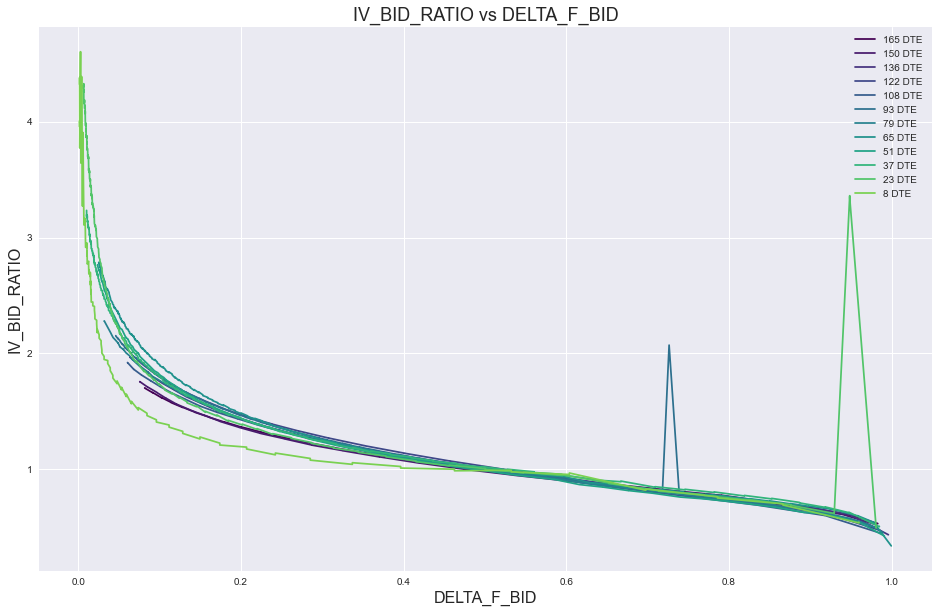

In [10]:
plot_IV_2D(df, "DELTA_F_BID", "IV_BID_RATIO", interval=10, otm=False, option_type="P")

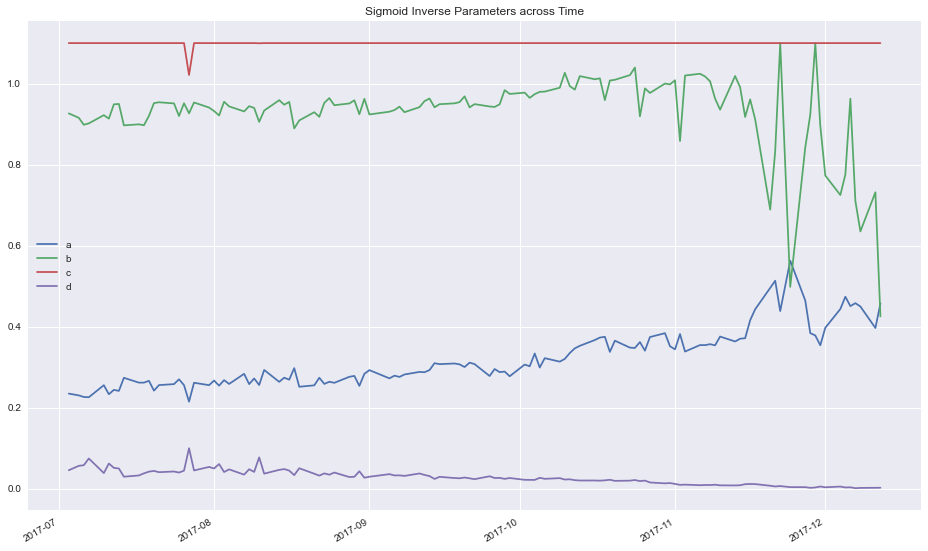

In [17]:
fit_df = pd.DataFrame(fits, index=to_fit["TS"].unique(), columns=['a', 'b', 'c', 'd'])

fit_df.plot()
plt.title("Sigmoid Inverse Parameters across Time")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


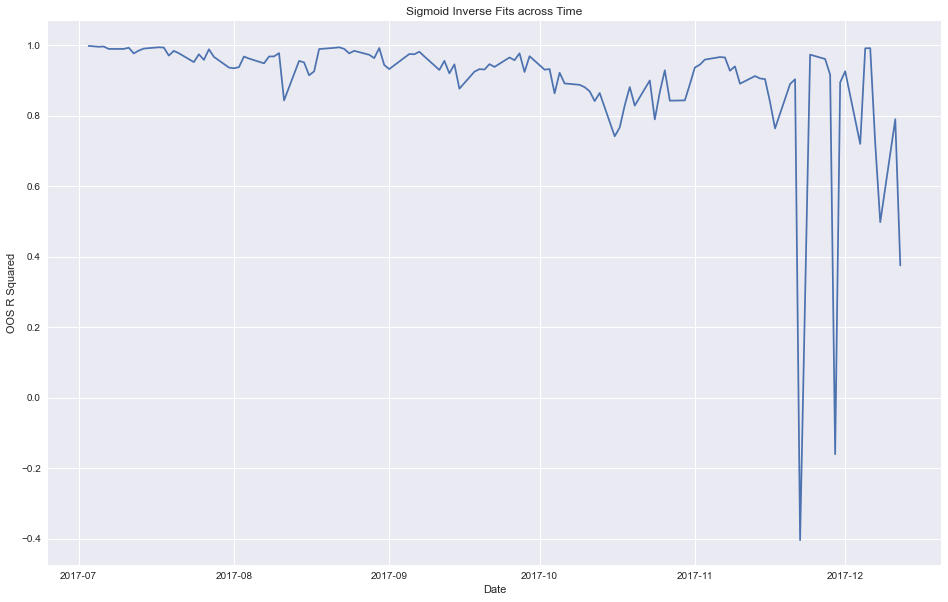

In [16]:
dte = to_fit["TS"].unique()#[::s]
eval = pd.DataFrame(index=dte)

for i in range(len(preds)):
    temp = to_fit[(to_fit["TS"]==dte[i])].copy().dropna()
    temp = temp[temp["IV_BID_RATIO"] < temp["IV_BID_RATIO"].values[-1]]
    # print(temp.index[0], temp.index[-1])
    pred = sigmoid_inv(temp["DELTA_F_BID"].values, *fits[0])
    
    fin = np.isfinite(pred)
    
    rsq = r2_score(pred[fin], temp["IV_BID_RATIO"].values[fin])
    eval.loc[dte[i], "rsq"] = rsq

plt.plot(eval["rsq"])

plt.title("Sigmoid Inverse Fits across Time")
plt.xlabel("Date")
plt.ylabel("OOS R Squared")
plt.legend()
plt.show()

# Model Theory

Definition of Delta:

$$\begin{aligned}
    C&= e^{-rT}FN(d_1)-KN(d_2)e^{-rT} \\
    d_1 &= \frac{\log ( F_T/K)+(\sigma^2/2)T}{\sigma\sqrt {T}} \\
    \frac{dC}{dF_T}&=e^{-rT}N(d_1)\\
    \frac{dP}{dF_T}&=e^{-rT}N(d_1)-1\\
\end{aligned}$$

Dropping the discount factor will simply gives delta as below:

$$\begin{aligned}
    \frac{dC}{dF_T}&=N(d_1)\\
    \frac{dP}{dF_T}&=N(d_1)-1\\
\end{aligned}$$

# Can We Say $\sigma_{ratio} = f(g(\sigma_{imp|K=k}, \sigma_{imp|K=F}))$?

We claim that $\sigma_{imp} \sim \frac{dP}{dF_T}=N(d_1)-1$ and therefore $\exists f : \sigma_{imp} = f(\frac{dP}{dF_T}) + \epsilon$. 

$$\begin{aligned}
    d_1 &= \frac{\log ( F/K)+(\sigma_{imp|K=k}^2/2)T}{\sigma\sqrt {T}} \\
    \sigma_{ratio} &= \frac{\sigma_{imp|K=k}}{\sigma_{imp|K=F}} = f(N(d_1)) \\
    N^{-1}(f^{-1}(\frac{\sigma_{imp|K=k}}{\sigma_{imp|K=F}})) &= \frac{\log ( F/K)+(\sigma_{imp|K=k}^2/2)T}{\sigma_{imp|K=k}\sqrt {T}} \\
    \log ( F/K) &= \sigma_{imp|K=k}\sqrt {T} N^{-1}(f^{-1}(\frac{\sigma_{imp|K=k}}{\sigma_{imp|K=F}})) - (\sigma_{imp|K=k}^2/2)T
\end{aligned}$$

What we end up with appears quadratic on first glance, but...
* We need to predict $\sigma$, not $\log ( F/K)$.
* The linear term's coefficient is actually also a function of $\sigma$.

$$\begin{aligned}
    x &= \sigma_{imp|K=k}\sqrt {T} \\
    \log ( F/K) &= x N^{-1}(f^{-1}(\frac{\sigma_{imp|K=k}}{\sigma_{imp|K=F}})) - \frac{x^2}{2}
\end{aligned}$$